In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set(context="notebook", style="whitegrid")

C:\Users\gunuk\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Acoustic Classification Model

In [4]:
acoustic_df = pd.read_csv("P/parkinsons.data")

In [5]:
#performing Exploratory Data Analysis 
print(acoustic_df.head())

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [6]:
print(acoustic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [7]:
#Missing Values
print(acoustic_df.isnull().sum())

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


In [8]:
print("Target distribution:\n", acoustic_df['status'].value_counts())

Target distribution:
 status
1    147
0     48
Name: count, dtype: int64


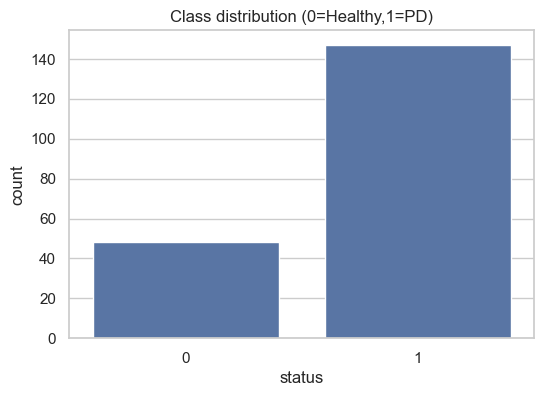

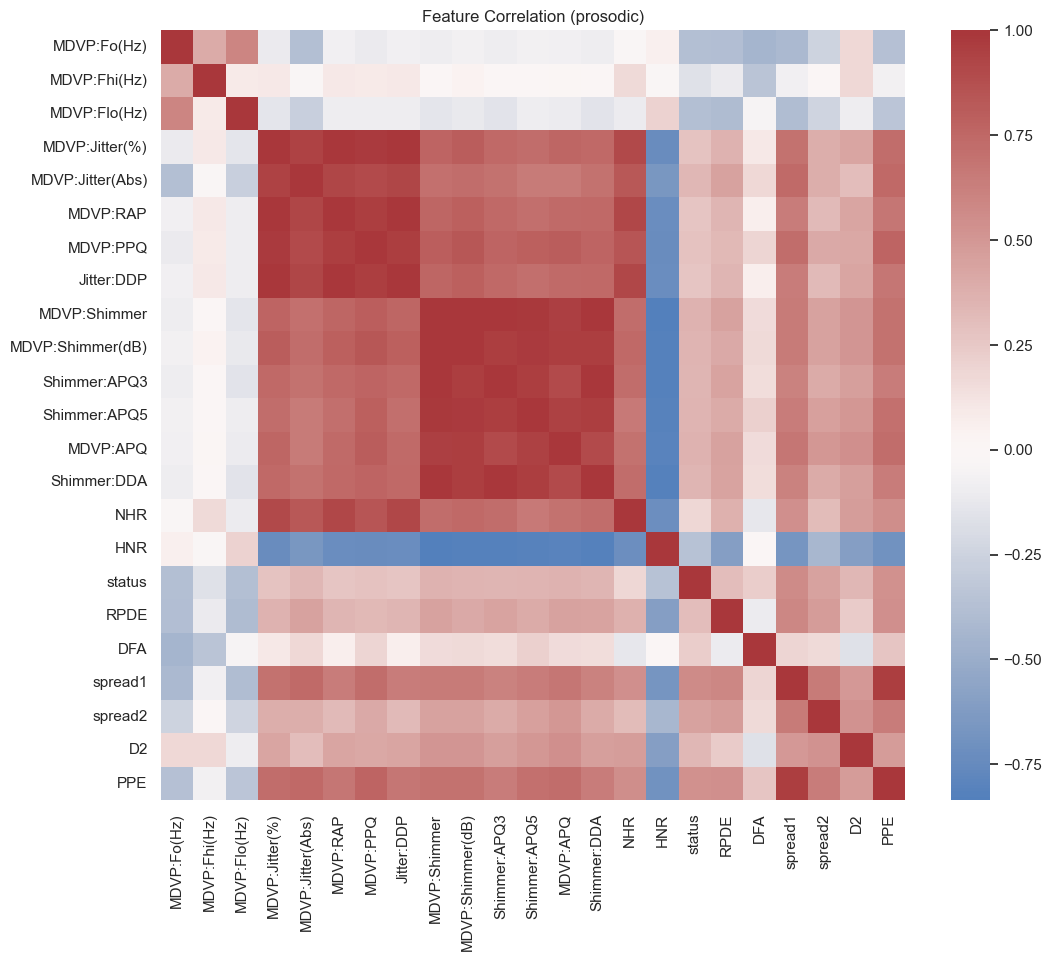

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=acoustic_df)
plt.title("Class distribution (0=Healthy,1=PD)")
plt.show()

# Correlation heatmap (drop name)
plt.figure(figsize=(12,10))
sns.heatmap(acoustic_df.drop(columns=['name']).corr(), cmap="vlag", center=0)
plt.title("Feature Correlation (prosodic)")
plt.show()


In [10]:
X = acoustic_df[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 
          'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 
          'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 
          'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR']]
y = acoustic_df['status']  # Binary target


In [11]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [12]:
# Scale features
ac_c_scaler = StandardScaler()
X_train_s = ac_c_scaler.fit_transform(X_train)
X_test_s  = ac_c_scaler.transform(X_test)

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM_RBF": SVC(kernel='rbf', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=36)
}



--- LogisticRegression ---
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.83      0.83      0.83        29

    accuracy                           0.74        39
   macro avg       0.66      0.66      0.66        39
weighted avg       0.74      0.74      0.74        39



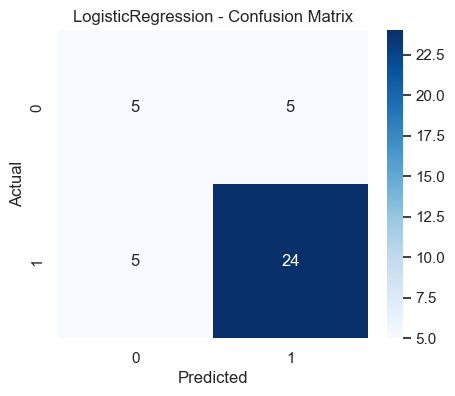


--- SVM_RBF ---
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.85      1.00      0.92        29

    accuracy                           0.87        39
   macro avg       0.93      0.75      0.79        39
weighted avg       0.89      0.87      0.86        39



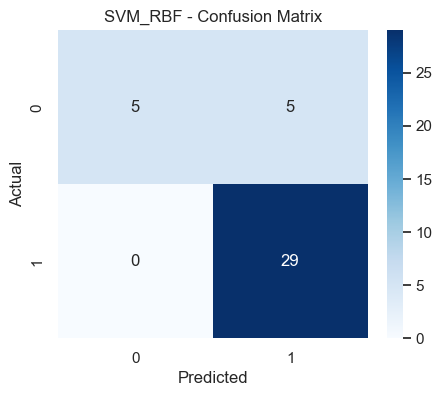


--- RandomForest ---
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



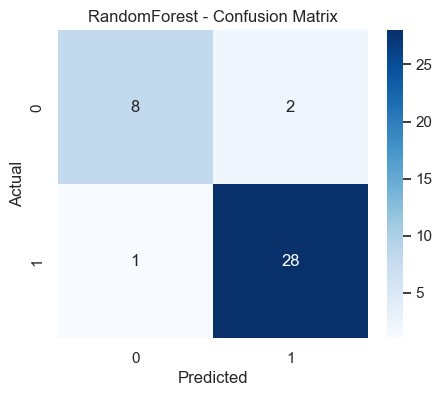

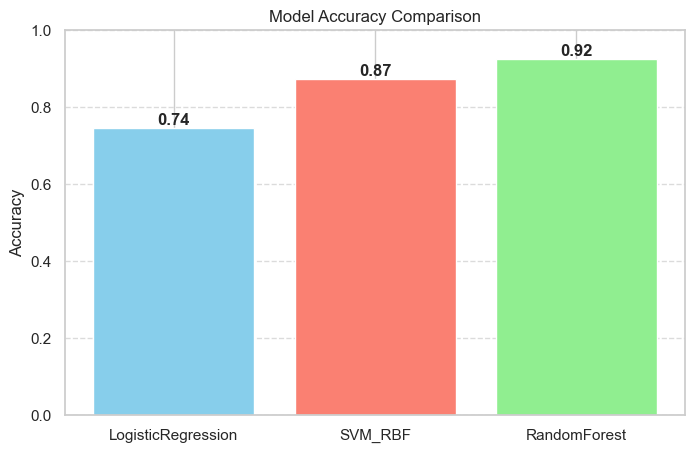

In [13]:
accuracy_scores = {}

# Train & evaluate
for name, model in models.items():
    model.fit(X_train_s, y_train)
    y_pred = model.predict(X_test_s)

    # Print classification report
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))

    # Store accuracy
    accuracy_scores[name] = accuracy_score(y_test, y_pred)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot accuracy comparison after all models
plt.figure(figsize=(8,5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['skyblue','salmon','lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy numbers on top of bars
for i, v in enumerate(accuracy_scores.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()

# Prosodic classficafication Model

In [14]:
prosodic_df= pd.read_csv("P/parkinsons.data")

In [15]:
print(prosodic_df.head())

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [16]:
X_p = prosodic_df[["RPDE", "D2", "DFA", "spread1", "spread2", "PPE"]]
y_p = prosodic_df['status']

In [49]:
# train/test split
X_pr_train, X_pr_test, y_pr_train, y_pr_test = train_test_split(X_p, y_p, test_size=0.4, random_state=42)

# scale
pr_c_scalerP = StandardScaler()
X_pr_train_s = pr_c_scalerP.fit_transform(X_pr_train)
X_pr_test_s  = pr_c_scalerP.transform(X_pr_test)


In [52]:
prosodic_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM_RBF": SVC(kernel='rbf', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=36)
}


--- LogisticRegression ---
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.83      0.83      0.83        29

    accuracy                           0.74        39
   macro avg       0.66      0.66      0.66        39
weighted avg       0.74      0.74      0.74        39



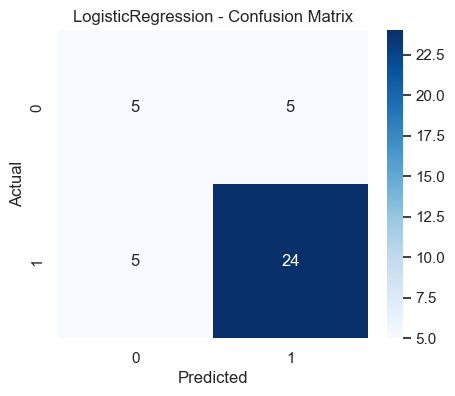


--- SVM_RBF ---
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.85      1.00      0.92        29

    accuracy                           0.87        39
   macro avg       0.93      0.75      0.79        39
weighted avg       0.89      0.87      0.86        39



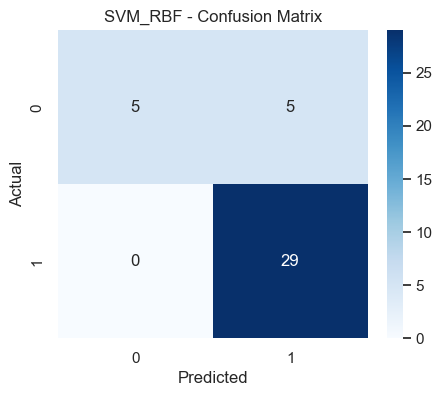


--- RandomForest ---
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



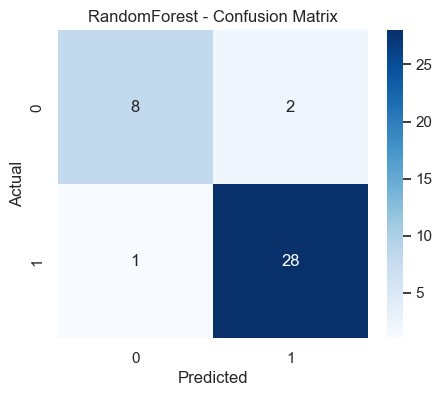

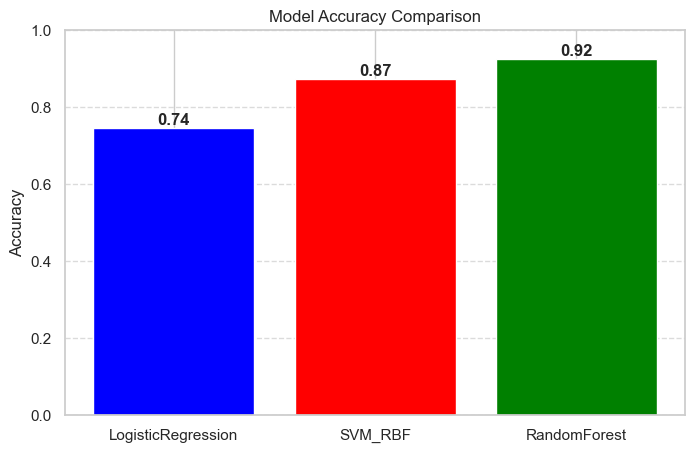

In [53]:
# Accuracy storage
pr_accuracy_scores = {}

# Train & evaluate
for name, pmodel in prosodic_models.items():
    pmodel.fit(X_train_s, y_train)
    y_pred = pmodel.predict(X_test_s)

    # Print classification report
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))

    # Store accuracy
    pr_accuracy_scores[name] = accuracy_score(y_test, y_pred)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot accuracy comparison after all models
plt.figure(figsize=(8,5))
plt.bar(pr_accuracy_scores.keys(), pr_accuracy_scores.values(), color=['blue','red','green'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy numbers on top of bars
for i, v in enumerate(pr_accuracy_scores.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()

# Acoustic Regression Model

In [24]:
acoustic_reg_df = pd.read_csv("P/telemonitoring/parkinsons_updrs.data")
print(acoustic_reg_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

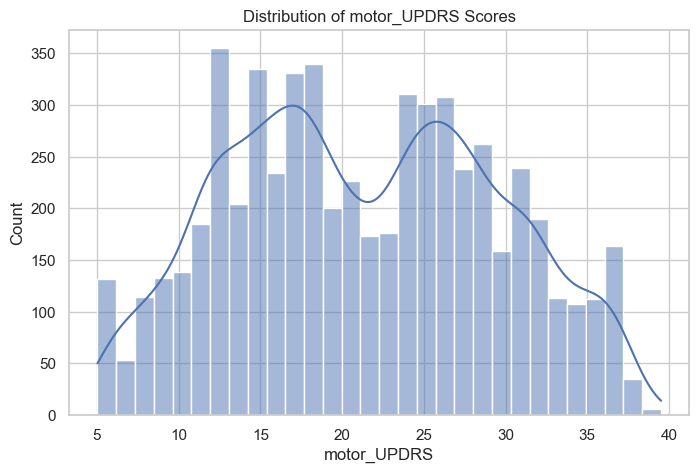

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(acoustic_reg_df["motor_UPDRS"], bins=30, kde=True)
plt.title("Distribution of motor_UPDRS Scores")
plt.xlabel("motor_UPDRS")
plt.ylabel("Count")
plt.show()


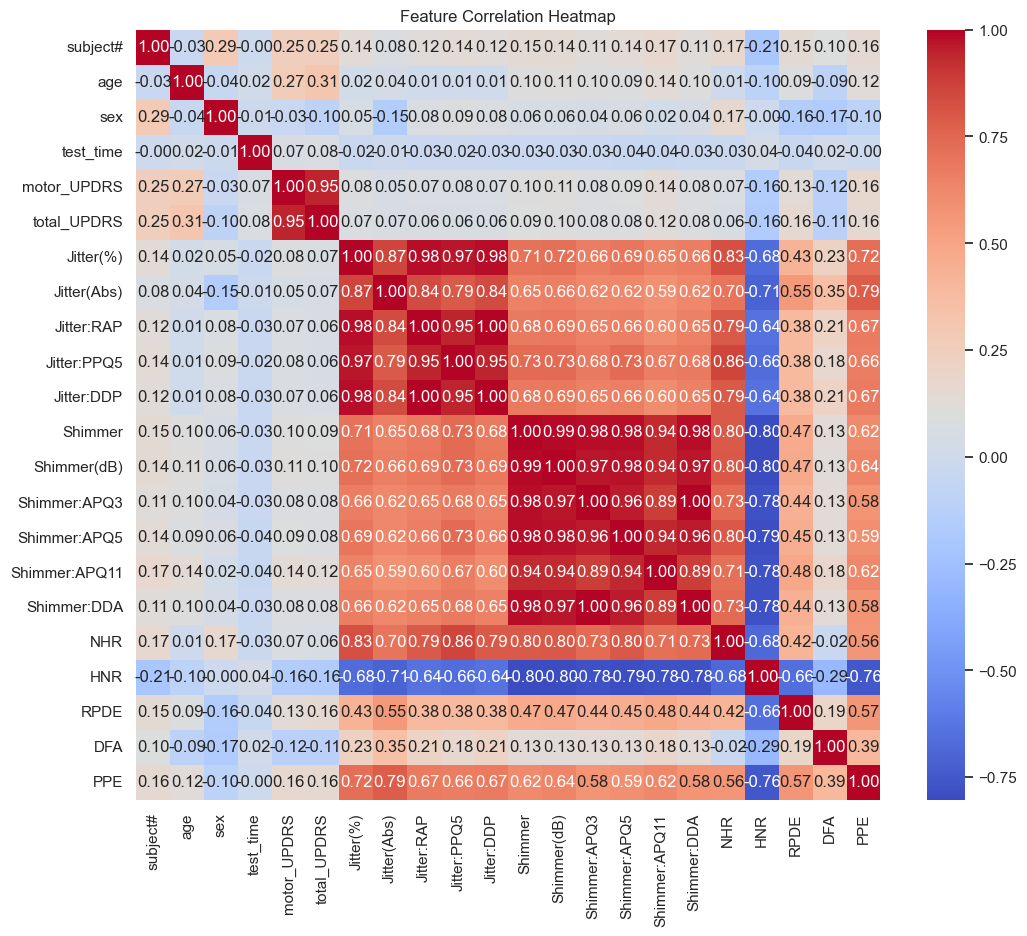

In [26]:
plt.figure(figsize=(12,10))
corr = acoustic_reg_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [27]:
ac_features = [ "Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP",
    "Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5", "Shimmer:APQ11",
    "Shimmer:DDA", "NHR", "HNR"]

In [28]:
demo_features = ["age","sex","test_time"]

In [29]:
ac_reg_combined_features = ac_features + demo_features

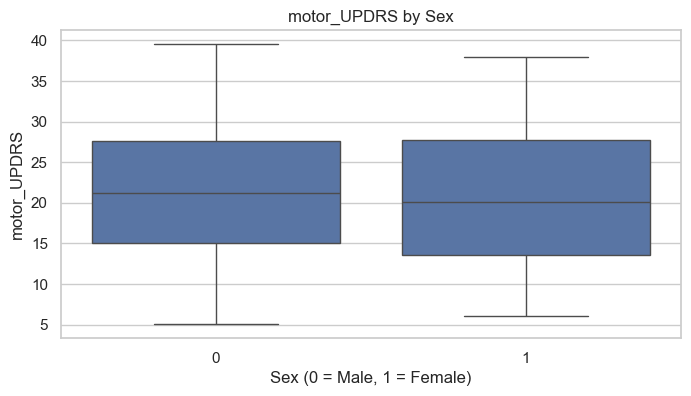

In [30]:
plt.figure(figsize=(8,4))
sns.boxplot(x="sex", y="motor_UPDRS", data=acoustic_reg_df)
plt.title("motor_UPDRS by Sex")
plt.xlabel("Sex (0 = Male, 1 = Female)")
plt.ylabel("motor_UPDRS")
plt.show()


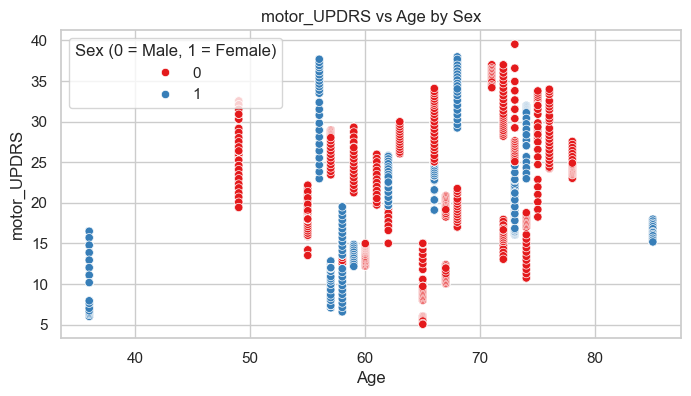

In [31]:
plt.figure(figsize=(8,4))
sns.scatterplot(x="age", y="motor_UPDRS", hue="sex", data=acoustic_reg_df, palette="Set1")
plt.title("motor_UPDRS vs Age by Sex")
plt.xlabel("Age")
plt.ylabel("motor_UPDRS")
plt.legend(title="Sex (0 = Male, 1 = Female)")
plt.show()


In [32]:
target = "motor_UPDRS"
X_ac_reg = acoustic_reg_df[ac_features]
y_ac_reg = acoustic_reg_df[target]

In [34]:
X_ac_reg_train, X_ac_reg_test, y_ac_reg_train, y_ac_reg_test = train_test_split(
    X_ac_reg, y_ac_reg, test_size=0.2, random_state=42
)

ac_r_scaler = StandardScaler()
X_ac_reg_train = ac_r_scaler.fit_transform(X_ac_reg_train)
X_ac_reg_test = ac_r_scaler.transform(X_ac_reg_test)


In [35]:
from sklearn.svm import SVR

In [36]:
ac_reg_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "SVR": SVR(kernel="rbf", C=100, epsilon=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42)
}

LinearRegression → Train R²: 0.060, Test R²: 0.046, Train MSE: 62.608, Test MSE: 60.908
Ridge → Train R²: 0.060, Test R²: 0.046, Train MSE: 62.614, Test MSE: 60.917
Lasso → Train R²: 0.060, Test R²: 0.043, Train MSE: 62.649, Test MSE: 61.087
SVR → Train R²: 0.209, Test R²: 0.150, Train MSE: 52.693, Test MSE: 54.273
RandomForest → Train R²: 0.897, Test R²: 0.229, Train MSE: 6.888, Test MSE: 49.231


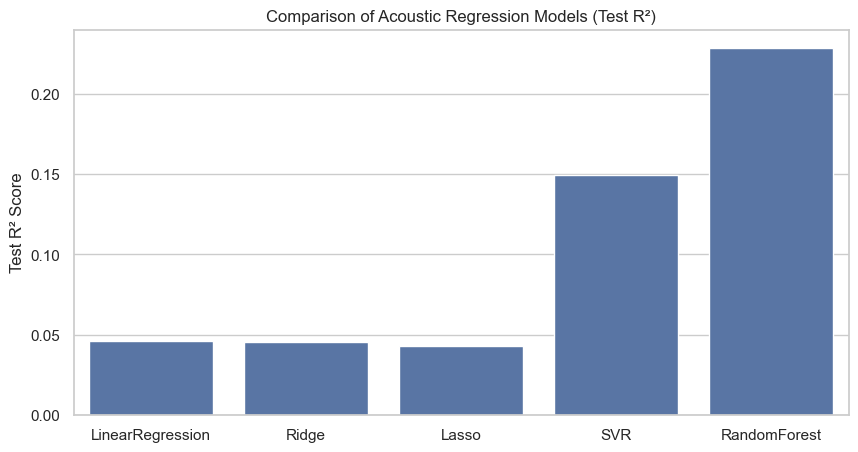

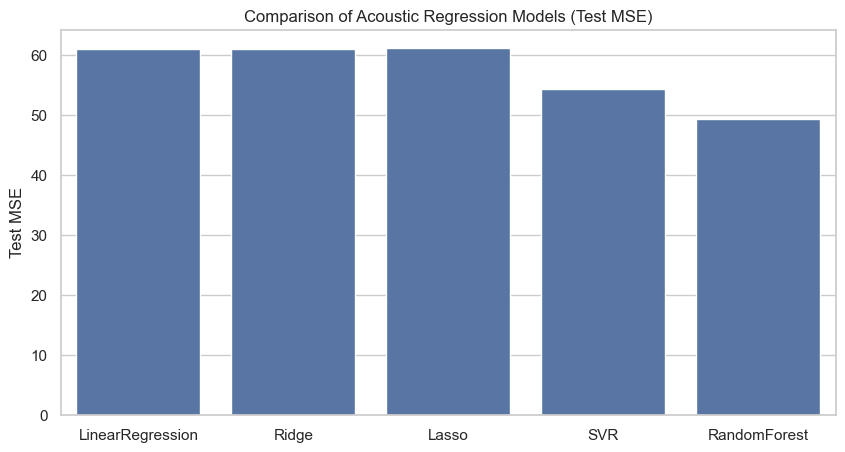

In [37]:
ac_reg_results = {}

for name, model in ac_reg_models.items():
    model.fit(X_ac_reg_train, y_ac_reg_train)
    test_pred = model.predict(X_ac_reg_test)
    train_pred = model.predict(X_ac_reg_train)
    
    train_r2 = r2_score(y_ac_reg_train, train_pred)
    test_r2 = r2_score(y_ac_reg_test, test_pred)
    train_mse = mean_squared_error(y_ac_reg_train, train_pred)
    test_mse = mean_squared_error(y_ac_reg_test, test_pred)
    
    ac_reg_results[name] = {
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Train MSE": train_mse,
        "Test MSE": test_mse
    }
    print(f"{name} → Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}, Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}")

# Plot R² scores
plt.figure(figsize=(10,5))
r2_df = {name: res["Test R²"] for name, res in ac_reg_results.items()}
sns.barplot(x=list(r2_df.keys()), y=list(r2_df.values()))
plt.ylabel("Test R² Score")
plt.title("Comparison of Acoustic Regression Models (Test R²)")
plt.show()

# Plot MSE scores
plt.figure(figsize=(10,5))
mse_df = {name: res["Test MSE"] for name, res in ac_reg_results.items()}
sns.barplot(x=list(mse_df.keys()), y=list(mse_df.values()))
plt.ylabel("Test MSE")
plt.title("Comparison of Acoustic Regression Models (Test MSE)")
plt.show()

# Prosodic Regression Model

In [38]:
prosodic_reg_df = pd.read_csv("P/telemonitoring/parkinsons_updrs.data")

In [39]:
prosodic_reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [40]:
pro_reg_features=[ "RPDE", "DFA", "PPE"]

In [41]:
pro_reg_combined_features = pro_reg_features + demo_features 

In [42]:
pr_target = "motor_UPDRS"
X_pr_reg = prosodic_reg_df[pro_reg_features]
y_pr_reg = prosodic_reg_df[pr_target]

In [43]:
X_pr_reg_train, X_pr_reg_test, y_pr_reg_train, y_pr_reg_test = train_test_split(
    X_pr_reg, y_pr_reg, test_size=0.2, random_state=42
)

pr_r_scaler = StandardScaler()
X_pr_reg_train = pr_r_scaler.fit_transform(X_pr_reg_train)
X_pr_reg_test = pr_r_scaler.transform(X_pr_reg_test)

In [44]:
pro_reg_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "SVR": SVR(kernel="rbf", C=100, epsilon=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42)
}

LinearRegression → Train R²: 0.070, Test R²: 0.050, Train MSE: 61.965, Test MSE: 60.666
Ridge → Train R²: 0.070, Test R²: 0.050, Train MSE: 61.965, Test MSE: 60.666
Lasso → Train R²: 0.070, Test R²: 0.050, Train MSE: 61.965, Test MSE: 60.653
SVR → Train R²: 0.177, Test R²: 0.120, Train MSE: 54.804, Test MSE: 56.186
RandomForest → Train R²: 0.873, Test R²: 0.061, Train MSE: 8.433, Test MSE: 59.926


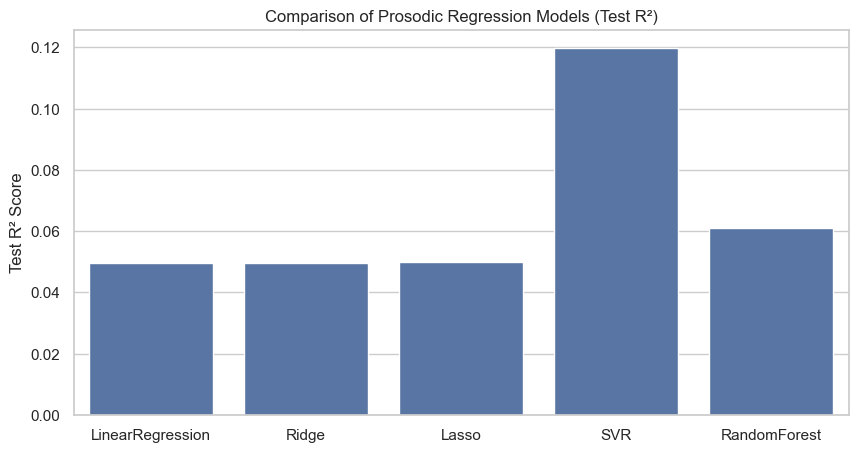

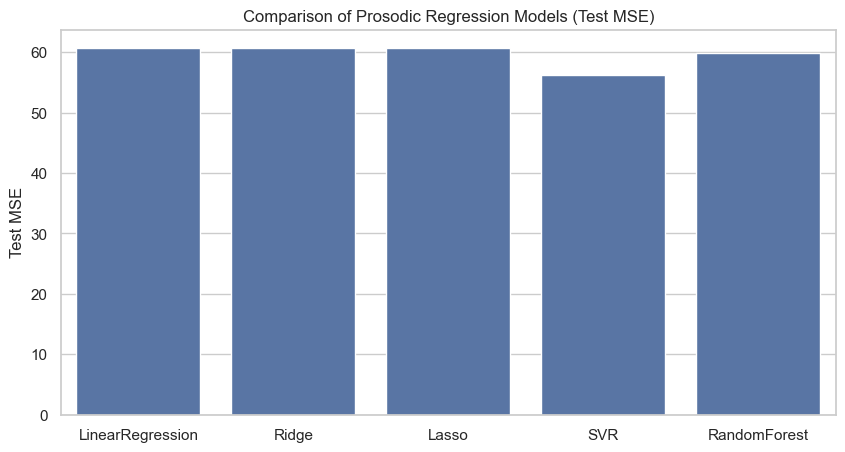

In [45]:
pr_reg_results = {}

for name, model in pro_reg_models.items():
    model.fit(X_pr_reg_train, y_pr_reg_train)
    test_pred = model.predict(X_pr_reg_test)
    train_pred = model.predict(X_pr_reg_train)
    
    train_r2 = r2_score(y_pr_reg_train, train_pred)
    test_r2 = r2_score(y_pr_reg_test, test_pred)
    train_mse = mean_squared_error(y_pr_reg_train, train_pred)
    test_mse = mean_squared_error(y_pr_reg_test, test_pred)
    
    pr_reg_results[name] = {
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Train MSE": train_mse,
        "Test MSE": test_mse
    }
    print(f"{name} → Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}, Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}")

# Plot Test R² scores
plt.figure(figsize=(10,5))
r2_df = {name: res["Test R²"] for name, res in pr_reg_results.items()}
sns.barplot(x=list(r2_df.keys()), y=list(r2_df.values()))
plt.ylabel("Test R² Score")
plt.title("Comparison of Prosodic Regression Models (Test R²)")
plt.show()

# Plot Test MSE scores
plt.figure(figsize=(10,5))
mse_df = {name: res["Test MSE"] for name, res in pr_reg_results.items()}
sns.barplot(x=list(mse_df.keys()), y=list(mse_df.values()))
plt.ylabel("Test MSE")
plt.title("Comparison of Prosodic Regression Models (Test MSE)")
plt.show()
